# Pierwszy i drugi milestone projektu 2. z przedmiotu WUM
### Alicja Charuza, Mateusz Gałęziewski

Poniżej przedstawiamy naszą pracę związaną z preprocessingiem danych oraz tworzeniem modeli uczenia nienadzorowanego na podstawie [zbioru danych na temat chorób serca](https://www.kaggle.com/datasets/kingabzpro/heart-disease-patients?select=heart_disease_patients.csv).

## #1 Preprocessing

In [157]:
#Importing libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')

Wczytywanie danych i podział na zbiór do budowy i do walidacji.

In [40]:
#loading data
def load_split():
    df = pd.read_csv('data/heart_disease_patients.csv')
    train_data, val_data = train_test_split(df, test_size=0.3, random_state=42)
    train_data.reset_index(inplace=True, drop=True)
    val_data.reset_index(inplace=True, drop=True)
    return train_data.drop(['id'], axis=1), val_data.drop(['id'], axis=1)

In [41]:
df, val_data = load_split()

In [42]:
#Let's check the shape of the dataset
df.shape, val_data.shape

((212, 11), (91, 11))

Sprawdźmy, jak wyglądają mniej więcej dane.

In [43]:
#What are the columns?
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope
0,65,1,1,138,282,1,2,174,0,1.4,2
1,62,1,4,120,267,0,0,99,1,1.8,2
2,57,1,3,150,168,0,0,174,0,1.6,1
3,57,1,4,140,192,0,0,148,0,0.4,2
4,58,0,4,100,248,0,2,122,0,1.0,2


Dowiedzmy się trochę więcej o wartościach w poszczególnych kolumnach.

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212 entries, 0 to 211
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       212 non-null    int64  
 1   sex       212 non-null    int64  
 2   cp        212 non-null    int64  
 3   trestbps  212 non-null    int64  
 4   chol      212 non-null    int64  
 5   fbs       212 non-null    int64  
 6   restecg   212 non-null    int64  
 7   thalach   212 non-null    int64  
 8   exang     212 non-null    int64  
 9   oldpeak   212 non-null    float64
 10  slope     212 non-null    int64  
dtypes: float64(1), int64(10)
memory usage: 18.3 KB


Czyli nie mamy żadnych wierszy z brakami danych.

Spróbujmy na podstawie informacji z kaggla, wyjaśnić znaczenie poszczególnych kolumn.

### Wyjaśnienie kolumn
|kolumna|opis|typ|
|:-:|:--|:-:|
|id|indeks|numeryczny|
|age|wiek|numeryczny|
|sex|płeć|kategoryczny|
|cp|typ bólu klatki piersiowej|kategoryczny|
|trestbps|ciśnienie krwi w spoczynku (w momencie przyjęcia do szpitala) w mm/Hg|numeryczny|
|chol|poziom cholesterolu w surowicy w mg/dl|numeryczny|
|fbs|poziom cukru na czczo w mg/dl > 120 (1 = true, 0 = false)|kategoryczny|
|restecg|wyniki ekg w spoczynku|kategoryczny|
|thalach|maksymalne tętno|numeryczny|
|exang|dławica wysiłkowa (1 = true, 0 = false)|kategoryczny|
|oldpeak|obniżenie odcinka ST wywołane wysiłkiem w porównaniu do spoczynku|numeryczny|
|slope|spadek odcinka ST podczas szczytowego wysiłku|kategoryczny|

### Wyjaśnienie jednostek
|jednostka|opis|
|:-:|:-:|
|mm/Hg|milimetry słupa rtęci|
|mg/dl|miligramy na decylitr|

Spójrzmy, jak wyglądają podstawowe statystyki zmiennych.

In [45]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope
count,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000
mean,54.712264,0.660377,3.117925,132.386792,245.905660,0.122642,0.985849,150.452830,0.339623,1.042453,1.599057
std,9.173279,0.474702,0.988205,18.690328,47.490289,0.328802,0.999899,22.125507,0.474702,1.212060,0.626885
min,34.000000,0.000000,1.000000,94.000000,149.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000
25%,47.000000,0.000000,2.000000,120.000000,212.000000,0.000000,0.000000,137.750000,0.000000,0.000000,1.000000
50%,55.500000,1.000000,3.000000,130.000000,240.500000,0.000000,0.000000,153.000000,0.000000,0.800000,2.000000
75%,62.000000,1.000000,4.000000,140.500000,273.000000,0.000000,2.000000,167.250000,1.000000,1.600000,2.000000
max,77.000000,1.000000,4.000000,200.000000,417.000000,1.000000,2.000000,195.000000,1.000000,6.200000,3.000000


Zastosujemy one hot encoding dla kolumn o wartościach kategorycznych z liczbą kategorii większą niż dwa. Są to *cp*, *restecg*, *slope*.

In [46]:
#Dealing with the categorical variables
enc = OneHotEncoder()
enc_data = pd.DataFrame(enc.fit_transform(df[['cp', 'restecg', 'slope']]).toarray())
encoded_column_names = enc.get_feature_names_out(['cp', 'restecg', 'slope'])
enc_data.columns = encoded_column_names
df = (df.drop(['cp', 'restecg', 'slope'], axis=1)).join(enc_data)

In [47]:
#There are new columns 
df.head()

,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,cp_1,cp_2,cp_3,cp_4,restecg_0,restecg_1,restecg_2,slope_1,slope_2,slope_3
0,65,1,138,282,1,174,0,1.4,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,62,1,120,267,0,99,1,1.8,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
2,57,1,150,168,0,174,0,1.6,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,57,1,140,192,0,148,0,0.4,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
4,58,0,100,248,0,122,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0


In [48]:
#There are no missing values
df.isnull().sum()

age          0
sex          0
trestbps     0
chol         0
fbs          0
thalach      0
exang        0
oldpeak      0
cp_1         0
cp_2         0
cp_3         0
cp_4         0
restecg_0    0
restecg_1    0
restecg_2    0
slope_1      0
slope_2      0
slope_3      0
dtype: int64

Spróbujemy teraz znormalizować/standaryzować dane. Jednak najpierw przyjrzyjmy się rozkładom poszczególnych zmiennych.

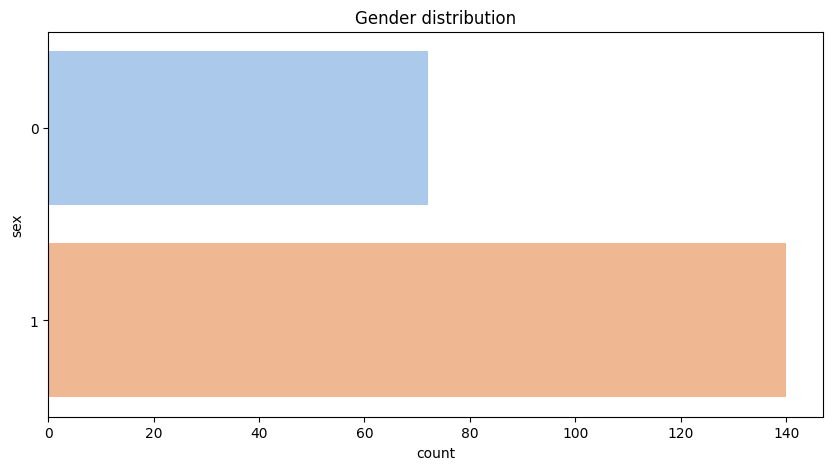

In [49]:
plt.figure(figsize=(10, 5))
sns.countplot(y='sex', data=df, palette='pastel')
plt.title('Gender distribution')
plt.show()

Jedna z płci stanowczo dominuje wśród badanych


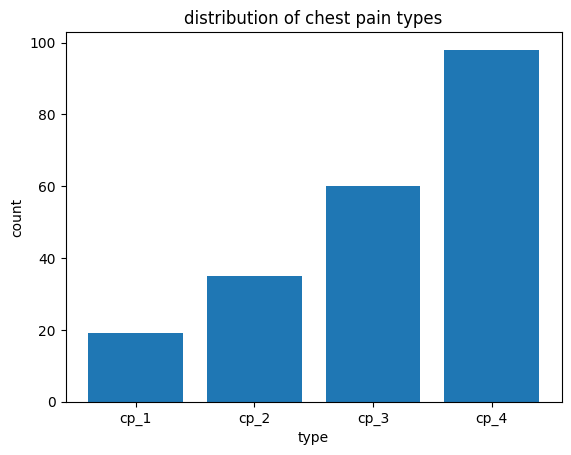

In [50]:
chest = ['cp_1','cp_2','cp_3','cp_4']
sum_values = df[chest].sum(axis=0)
plt.bar(chest, sum_values)
plt.title('distribution of chest pain types')
plt.xlabel('type')
plt.ylabel('count')
plt.show()


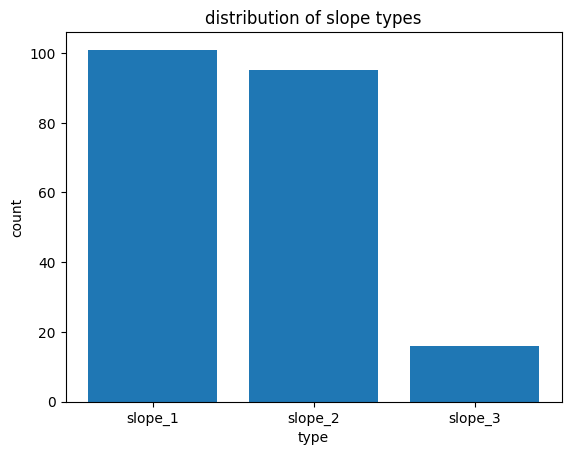

In [51]:
slope = ['slope_1','slope_2','slope_3']
sum_values = df[slope].sum(axis=0)
plt.bar(slope, sum_values)
plt.title('distribution of slope types')
plt.xlabel('type')
plt.ylabel('count')
plt.show()

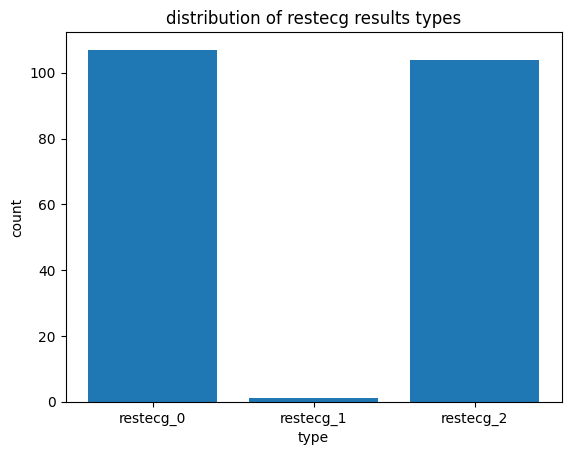

In [52]:
restecg = ['restecg_0','restecg_1','restecg_2']
sum_values = df[restecg].sum(axis=0)
plt.bar(restecg, sum_values)
plt.title('distribution of restecg results types')
plt.xlabel('type')
plt.ylabel('count')
plt.show()

Text(0.5, 1.0, 'age')

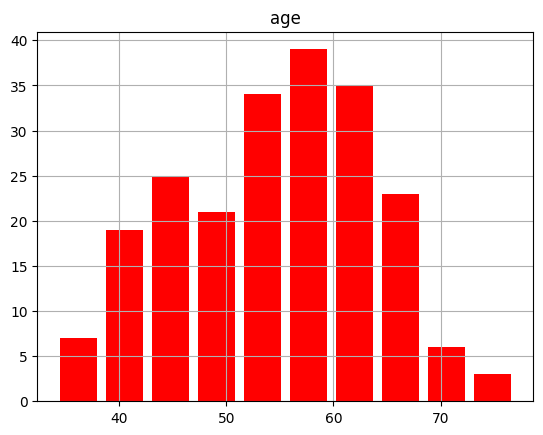

In [53]:
df['age'].hist(rwidth=0.8 , color='red')
plt.title('age')

Text(0.5, 1.0, 'trestbps')

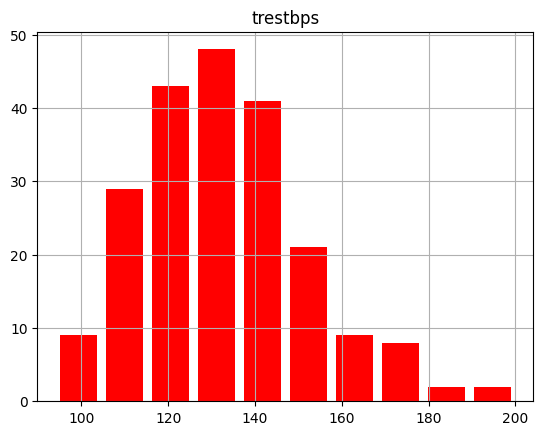

In [54]:
df['trestbps'].hist(rwidth=0.8, color='red')
plt.title('trestbps')

Text(0.5, 1.0, 'chol')

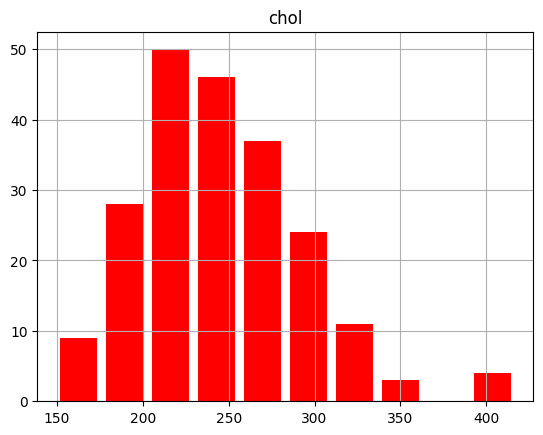

In [55]:
df['chol'].hist(rwidth=0.8 , color='red')
plt.title('chol')

Text(0.5, 1.0, 'thalach')

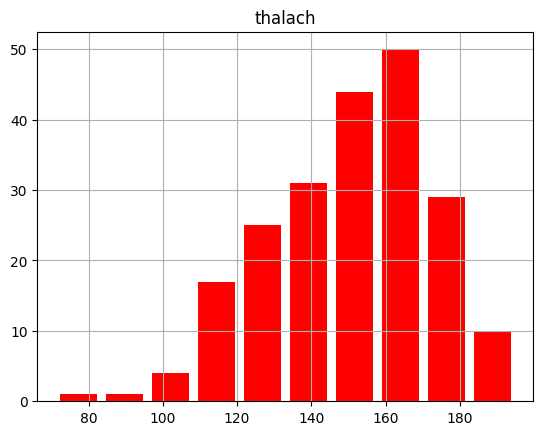

In [56]:
df['thalach'].hist(rwidth=0.8, color='red')
plt.title('thalach')

Text(0.5, 1.0, 'oldpeak')

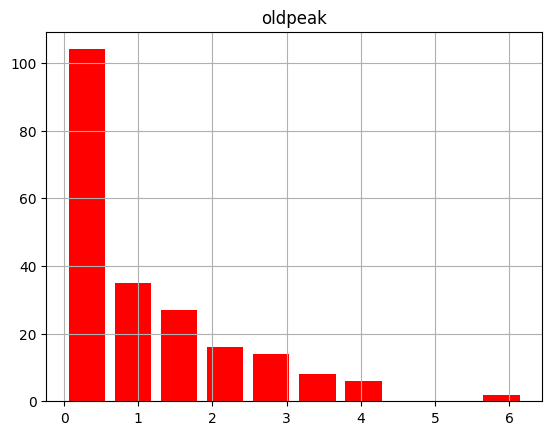

In [57]:
df['oldpeak'].hist(rwidth=0.8, color='red')
plt.title('oldpeak')

Na powyższych wykresach widać różną stronę, w którą "zmierza" skośność w rozkładach poszczególnych zmiennych 

Kierując się intuicją w zakresie interpretacji danych medycznych, nic nie robimy z wartościami odstającymi, ponieważ są w tym przypadku nośnikiem informacji nt. zdrowia pacjentów. 

### Zobaczmy jak silne są zależności liniowe między zmiennymi, policzymy współczynnik korelacji Pearsona.

Najpierw tworzymy heatmapę dla zmiennych kategorycznych, które nie podległy encodingowy zmiennych.

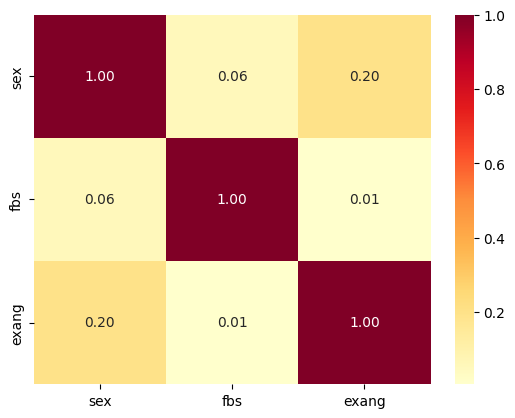

In [59]:
categorical_column = ['sex','fbs','exang']
df_categorical = df[categorical_column]
corr_matrix = df_categorical.corr(method='pearson')
#Let's see the correlation heatmap
plt.figure()
sns.heatmap(corr_matrix, annot=True, cmap = 'YlOrRd', fmt= '.2f')
plt.show()

Potem obliczamy korelację dla zmiennych ciągłych, numerycznych.

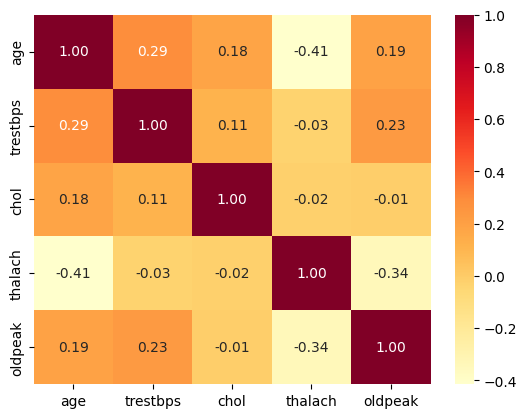

In [60]:
df_numeric = df[col]
num_corr_matrix = df_numeric.corr(method='pearson')
#Let's see the correaltion heatmap
plt.figure()
sns.heatmap(num_corr_matrix, annot=True, cmap = 'YlOrRd', fmt= '.2f')
plt.show()

Nie stwierdzamy występowania silnych współzależności liniowych w naszych danych. Możemy jednynie wyróżnić słabą negatywną korelację między wiekiem pacjenta [age], a maksymalnym pomierzonym tętnem [thalach].  Wynika z niej, że im pacjent jest starszy, tym tętno jest niższe.

### Przeprowadzamy normalizację i patrzymy jak wstępnie wyglądają nasze dane

In [61]:
normalize = MinMaxScaler()
X_n = normalize.fit_transform(df)
X_normal = pd.DataFrame(X_n, columns=df.columns)
X_normal.head()

,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,cp_1,cp_2,cp_3,cp_4,restecg_0,restecg_1,restecg_2,slope_1,slope_2,slope_3
0,0.720930,1.0,0.415094,0.496269,1.0,0.830645,0.0,0.225806,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,0.651163,1.0,0.245283,0.440299,0.0,0.225806,1.0,0.290323,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0.534884,1.0,0.528302,0.070896,0.0,0.830645,0.0,0.258065,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,0.534884,1.0,0.433962,0.160448,0.0,0.620968,0.0,0.064516,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0.558140,0.0,0.056604,0.369403,0.0,0.411290,0.0,0.161290,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0


Poniżej zastosujemy T-SNE do wizualizacji naszych danych.

<Axes: xlabel='comp-1', ylabel='comp-2'>

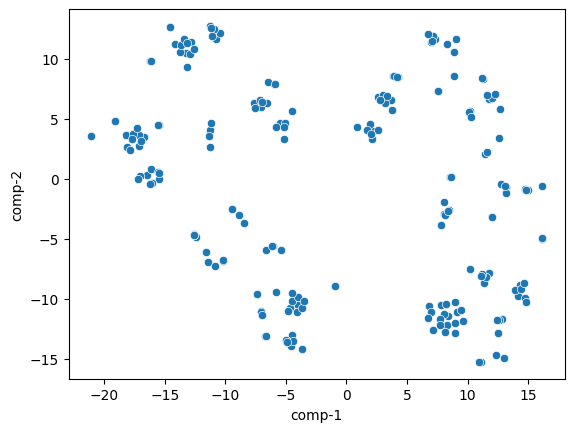

In [146]:
tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=20).fit_transform(X_normal)
df1 = pd.DataFrame()
df1["comp-1"] = tsne[:,0]
df1["comp-2"] = tsne[:,1]
sns.scatterplot(x="comp-1", y="comp-2",
                palette=sns.color_palette("hls", 10),
                data=df1)

### Funkcja do preprocessingu dla zespołu walidacyjnego

In [63]:
class Data_Processor:

    def __init__(self):
        self.train_data = None
        self.val_data = None

    def load_split(self, file_path):
        df = pd.read_csv(file_path)
        train_data, val_data = train_test_split(df, test_size=0.3, random_state=42)
        train_data.reset_index(inplace=True, drop=True)
        val_data.reset_index(inplace=True, drop=True)
        train_data.drop(['id'], axis=1)
        val_data.drop(['id'], axis=1)
        self.train_data = train_data
        self.val_data = val_data

    def encode_data(self):
        enc = OneHotEncoder()
        enc_train_data = pd.DataFrame(enc.fit_transform(self.train_data[['cp', 'restecg', 'slope']]).toarray())
        enc_val_data = pd.DataFrame(enc.transform(self.val_data[['cp', 'restecg', 'slope']]).toarray())
        encoded_column_names = enc.get_feature_names_out(['cp', 'restecg', 'slope'])
        enc_train_data.columns = encoded_column_names
        enc_val_data.columns = encoded_column_names
        self.train_data = (self.train_data.drop(['cp', 'restecg', 'slope'], axis=1)).join(enc_train_data)
        self.val_data = (self.val_data.drop(['cp', 'restecg', 'slope'], axis=1)).join(enc_val_data)
    
    def normalize_data(self):
        normalize = MinMaxScaler()
        norm_train = normalize.fit_transform(self.train_data)
        norm_val = normalize.transform(self.val_data)
        self.train_data = pd.DataFrame(norm_train, columns=self.train_data.columns)
        self.val_data = pd.DataFrame(norm_val, columns=self.val_data.columns)

    def get_train_data(self):
        return self.train_data
    
    def get_val_data(self):
        return self.val_data

Funkcja do rysowania wizualizacji przy użyciu T-SNE.


In [127]:
def t_sne(X, pred, perplexity):
    tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=perplexity).fit_transform(X)
    df1 = pd.DataFrame()
    df1['y'] = pred
    df1["comp-1"] = tsne[:,0]
    df1["comp-2"] = tsne[:,1]
    sns.scatterplot(x="comp-1", y="comp-2", hue=df1.y.tolist(),
                palette=sns.color_palette("hls", 10),
                data=df1)

Zobaczmy teraz, jak modele poradzą sobie z klasteryzacją.

## #2 Modele

In [65]:
dp = Data_Processor()
dp.load_split('data/heart_disease_patients.csv')
dp.encode_data()
dp.normalize_data()
X = dp.get_train_data()

### KMeans

Najpierw za pomocą metody łokcia, sprawdźmy optymalną liczbę klastrów do algorytmu KMeans.

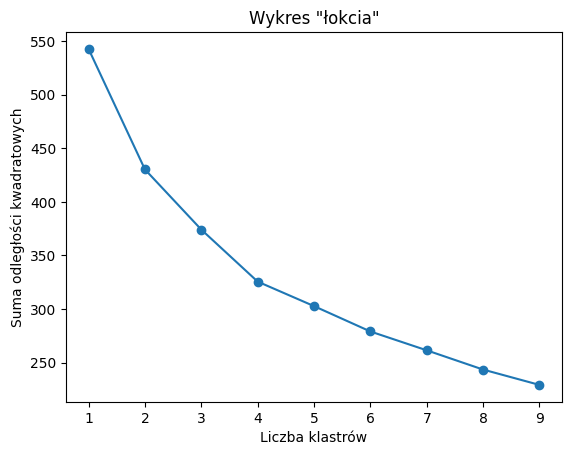

In [68]:
cluster_nums = range(1, 10)
inertias = []

for num in cluster_nums:
    kmeans = KMeans(n_clusters=num)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)

plt.plot(cluster_nums, inertias, marker='o')
plt.xlabel('Liczba klastrów')
plt.ylabel('Suma odległości kwadratowych')
plt.title('Wykres "łokcia"')
plt.show()

Według nas "łokieć" znajduje się w punkcie dla czterech, bądź dwóch klastrów. Sprawdźmy zatem model KMeans dla tych liczb.

Cztery klasty

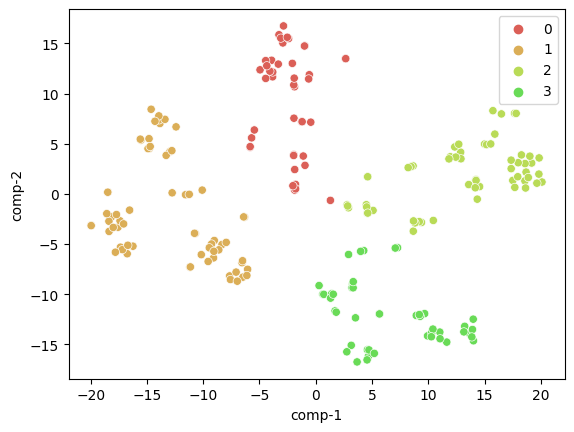

In [141]:
kmeans4 = KMeans(n_clusters=4)
pred4 = kmeans4.fit_predict(X)
t_sne(X, pred4, 20)

Sugerując się wizualizacją uzyskaną za pomocą T-SNE, możemy stwierdzić, że algorytm KMeans całkiem dobrze poradził sobie z klasteryzacją. Jednak jest to jedynie narzędzie do wizualizacji i analizy danych, więc sprawdźmy jeszcze autentyczne wyniki.

In [150]:
print('Inertia:')
print('(im niższa tym lepiej)')
print(kmeans4.inertia_)
print('Silhouette Score:')
print('(im bliżej 1 tym lepiej)')
print(silhouette_score(X, kmeans4.labels_))
print('Miara odległości między klastrami:')
print('(im większa tym lepiej)')
print(np.mean(euclidean_distances(kmeans4.cluster_centers_)))

Inertia:
(im niższa tym lepiej)
325.6094892733451
Silhouette Score:
(im bliżej 1 tym lepiej)
0.2188828515840771
Miara odległości między klastrami:
(im większa tym lepiej)
1.2177572631304803


Dwa klastry

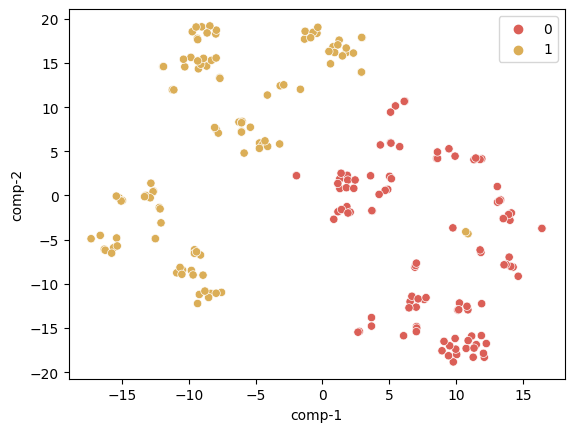

In [151]:
kmeans2 = KMeans(n_clusters=2)
pred2 = kmeans.fit_predict(X)
t_sne(X, pred2, 20)

In [152]:
print('Inertia:')
print('(im niższa tym lepiej)')
print(kmeans2.inertia_)
print('Silhouette Score:')
print('(im bliżej 1 tym lepiej)')
print(silhouette_score(X, kmeans2.labels_))
print('Miara odległości między klastrami:')
print('(im większa tym lepiej)')
print(np.mean(euclidean_distances(kmeans2.cluster_centers_)))

Inertia:
(im niższa tym lepiej)
430.19660712626063
Silhouette Score:
(im bliżej 1 tym lepiej)
0.20219469950438304
Miara odległości między klastrami:
(im większa tym lepiej)
0.728092551647351


Wszystkie sprawdzane przez nas metryki wypadły lepiej w przypadku dla czterech klastrów. Dlatego też zdecydujemy się użyć czterech.

Spróbujmy jeszcze dostosować parametry, aby sprawdzić czy damy radę poprawić osiągi modelu KMeans.

In [158]:
kmeans = KMeans()
param_grid = {
    'init': ['k-means++', 'random'],
    'n_init': [5, 10, 15, 20],
    'max_iter': range(100, 301, 10),
    'tol': [0.0001, 0.001, 0.01]
}
random_search = RandomizedSearchCV(kmeans, param_grid, cv=5)
random_search.fit(X)
best_params = random_search.best_params_
print("Najlepsze parametry:", best_params)

Najlepsze parametry: {'tol': 0.001, 'n_init': 20, 'max_iter': 110, 'init': 'k-means++'}


### Hierarchical Clustering 

### DBSCAN

### GMM

### Agglomerative Clustering